In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from person_processing import PersonProcessing
import pickle

## Process the data with the sampler and segmenter
with open('Data\\train_inputs.pkl', 'rb') as handle:
    list_of_trains = pickle.load(handle)
    
# parameter k
k = 5    
# dict with key k number of samples taken and value list of vectors for that particular k
# dict with key k number of segmentations taken and value list of vectors for that particular k
dict_of_k_samples_features = dict()
dict_of_k_segmentations_features = dict()
for train_sample in list_of_trains:
    for curr_k in range(2,k+1):
        person_processing_obj = PersonProcessing(train_sample)
        results_sampling = person_processing_obj.get_sampling(k=curr_k)
        results_segmentation = person_processing_obj.get_segmentation(k=curr_k)

        if curr_k in dict_of_k_samples_features:
            dict_of_k_samples_features[curr_k].append(results_sampling)
        else:
            dict_of_k_samples_features[curr_k] = list()
            dict_of_k_samples_features[curr_k].append(results_sampling)

        if curr_k in dict_of_k_segmentations_features:
            dict_of_k_segmentations_features[curr_k].append(results_segmentation)
        else:
            dict_of_k_segmentations_features[curr_k] = list()
            dict_of_k_segmentations_features[curr_k].append(results_segmentation)

In [ ]:
dict_of_k_segmentations_features[5][269]

In [ ]:
## Process the labels
with open('Data\\train_outputs.pkl', 'rb') as handle:
    list_of_train_labels_raw = pickle.load(handle)

In [ ]:
list_of_train_labels = list()
for item in list_of_train_labels_raw:
    label_idx = (item[0] == 1).nonzero()[0][0]
    list_of_train_labels.append(label_idx)

In [ ]:
## Neural Network Architecture
from torch import nn

class JapaneseVowelsNN(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(JapaneseVowelsNN, self).__init__()
        
        self.input_layer = nn.Linear(feature_dim, feature_dim*2)
        self.hidden_layer = nn.Linear(feature_dim*2, feature_dim)
        self.output_layer = nn.Linear(feature_dim, num_classes) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        #self.batchnorm1 = nn.BatchNorm1d(512)
        #self.batchnorm2 = nn.BatchNorm1d(128)
        #self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.input_layer(x)
        #x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output_layer(x)
        
        return x

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

## Function for creating the data loaders and making train validate sets
def data_loaders_creator(type='segmentation', k=2, val_split=0.2):
    if type=='segmentation':
        dataset = list(zip(torch.from_numpy(np.array(dict_of_k_segmentations_features[k])), torch.from_numpy(np.array                         (list_of_train_labels))))
    elif type=='sampling':
        dataset = list(zip(torch.from_numpy(np.array(dict_of_k_samples_features[k])), torch.from_numpy(np.array                         (list_of_train_labels))))

    train_data, val_data = train_test_split(dataset, test_size=val_split, random_state=42)

    train_data_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
    val_data_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=False)
    return train_data_loader, val_data_loader

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [ ]:
## Constant Parameters
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_CLASSES = 9
# Possible types: "segmentation" and "sampling"
TYPE_OF_FEATURES = "segmentation"

In [ ]:
from torch import optim
import torch 

## Loss function and Optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dict_of_k_results = dict()

for k in range(2,k+1):
    # Create data loaders and train val splits
    train_loader, val_loader = data_loaders_creator(k=k)
    feature_dim = next(iter(train_loader))[0].shape[1]

    ## Initialize model
    model = JapaneseVowelsNN(feature_dim=feature_dim, num_classes=NUM_CLASSES)
    model.to(device)
    model = model.double()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, EPOCHS+1):
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            
            y_train_pred = model(X_train_batch)
            
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
            
            train_loss.backward()
            optimizer.step()
            
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
            
            
        # VALIDATION    
        with torch.no_grad():
            
            val_epoch_loss = 0
            val_epoch_acc = 0
            
            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                
                y_val_pred = model(X_val_batch)
                            
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)
                
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        ## Check if key exists and create it if it doesnt and saves the results for the current experiment
        if not k in dict_of_k_results:
            dict_of_k_results[k] = {'train_acc':[], 'train_loss':[], 'val_acc':[],'val_loss':[],'type':TYPE_OF_FEATURES}
        dict_of_k_results[k]['train_acc'].append(train_epoch_acc/len(train_loader))
        dict_of_k_results[k]['train_loss'].append(train_epoch_loss/len(train_loader))
        dict_of_k_results[k]['val_acc'].append(val_epoch_acc/len(val_loader))
        dict_of_k_results[k]['val_loss'].append(val_epoch_loss/len(val_loader))
                                
        
        print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len          (val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader)             :.3f}')

In [ ]:
dict_of_k_results[2]

Text(0.5, 1.0, 'Train/Val accuracy for the Average Segmentation Method with different K values')

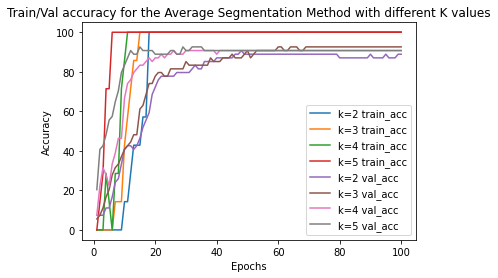

In [51]:
import matplotlib.pyplot as plt

plt.plot(range(1,EPOCHS+1), dict_of_k_results[2]['train_acc'], label = "k=2 train_acc")
plt.plot(range(1,EPOCHS+1), dict_of_k_results[3]['train_acc'], label = "k=3 train_acc")
plt.plot(range(1,EPOCHS+1), dict_of_k_results[4]['train_acc'], label = "k=4 train_acc")
plt.plot(range(1,EPOCHS+1), dict_of_k_results[5]['train_acc'], label = "k=5 train_acc")

plt.plot(range(1,EPOCHS+1), dict_of_k_results[2]['val_acc'], label = "k=2 val_acc")
plt.plot(range(1,EPOCHS+1), dict_of_k_results[3]['val_acc'], label = "k=3 val_acc")
plt.plot(range(1,EPOCHS+1), dict_of_k_results[4]['val_acc'], label = "k=4 val_acc")
plt.plot(range(1,EPOCHS+1), dict_of_k_results[5]['val_acc'], label = "k=5 val_acc")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.title('Train/Val accuracy for the Average Segmentation Method with different K values')